In [4]:
import pandas as pd
%matplotlib inline
%run Pipeline//upload_and_vizualize 
%run Pipeline//classify_and_evaluate 
%run Pipeline//aux_1
%run Pipeline//ULAB_ML_Pipeline
%run Pipeline//processing
import numpy as np 
import matplotlib.pyplot as plt
import pylab
import sys
import random
import sklearn as sk 
import json 
import re
from multiprocessing import Pool
from functools import partial
from time import time
from sklearn import svm, ensemble
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.linear_model import OrthogonalMatchingPursuit, RandomizedLogisticRegression
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.cross_validation import train_test_split, KFold
from sklearn.preprocessing import *
from sklearn.feature_selection import RFE
from sklearn.grid_search import ParameterGrid
from sklearn.svm import LinearSVC
from sklearn.metrics import *
import csv
from errno import EEXIST
from os import makedirs,path
from datetime import datetime as dr
from datetime import date
import numpy as np
import matplotlib
matplotlib.style.use('ggplot')
import pylab as pl
from upload_and_vizualize import camel_to_snake
from datetime import datetime as dt
from datetime import date

In [1]:
def general_read_file(df_dict, table_name, start_date, end_date):
    df = pd.DataFrame()
    
    table = df_dict[table_name]
    data_file = table['data_file']
    date_col = table['date_col']
    DATE_FORMAT = table['date_format']
    features = table['interest_var']
    
    df = read_file(data_file)
    
    if table == 'violation':
        df = violation[violation['ENF_RESPONSE_POLICY_CODE'] != 'FRV']
            
    df = filter_date(df, DATE_FORMAT, date_col, start=start_date, end=end_date)
    df = filter_col(df, fac_id, features, date_col)
        
    return df


def process_violation(violation_df, start_year, end_year):
    final_df = pd.DataFrame()
    
    outcome = ['ENF_RESPONSE_POLICY_CODE']
    cat_var = ['AGENCY_TYPE_DESC', 'AIR_LCON_CODE']
    dum_var = ['PROGRAM_CODES', 'POLLUTANT_CODES']
    
    df = violation_df[violation_df['HPV_DAYZERO_DATE_year'] >= start_year]
    df = df[df['HPV_DAYZERO_DATE_year'] <= end_year]
    
    ## Replace NaN with 'None' (string) --> Making 'None' it's own category
    nan = df.columns[df.isnull().any()].tolist()
    values = ['None']*len(nan)
    replace_with_value(df, nan, values)
    
    ## Dummitize 
    df, colnames_out = add_dummy(df, outcome, drop_original = True)
    df, colnames_dum = add_dummy(df, dum_var, sep_char = ' ')
    
    #return df
    df['id_+_date'] = df.PGM_SYS_ID +'_'+ df.HPV_DAYZERO_DATE_year
            
    final_df = aggr_dummy_cols(df, final_df, cat_var, 'cat')
    final_df = aggr_dummy_cols(df, final_df, colnames_dum, 'dum')
    final_df = aggr_dummy_cols(df, final_df, colnames_out)
    
    '''re_separate = r'(.[^_]*)_(.*)'
    sep = lambda x: pd.Series([i for i in re.split(re_separate,x)])
    final_id_year = final_df['id_+_date'].apply(sep)
    final_df =pd.concat([final_id_year.rename(columns={1:'PGM_SYS_ID',2:'HPV_DAYZERO_DATE_year'}), final_df], axis=1)
    final_df.drop([0, 3, 'id_+_date'], axis = 1, inplace = True)
'''
    
    return final_df


def process_inspection(inspection_df, start_year, end_year):
    final_df = pd.DataFrame()
    
    cat_var = ['STATE_EPA_FLAG','COMP_MONITOR_TYPE_CODE']
    dum_var = ['PROGRAM_CODES']
    
    df = inspection_df[inspection_df['ACTUAL_END_DATE_year'] >= start_year]
    df = df[df['ACTUAL_END_DATE_year'] <= end_year]
    
    ## Replace NaN with 'None' (string) --> Making 'None' it's own category
    nan = df.columns[df.isnull().any()].tolist()
    values = ['None']*len(nan)
    replace_with_value(df, nan, values)
    
    ## Dummitize 
    df, colnames_dum = add_dummy(df, dum_var, sep_char = ',') 
    
    df['id_+_date'] = df.PGM_SYS_ID +'_'+ df.ACTUAL_END_DATE_year
            
    final_df = aggr_dummy_cols(df, final_df, cat_var, 'cat')
    final_df = aggr_dummy_cols(df, final_df, colnames_dum, 'dum')
    
    return final_df


def process_titlev(titlev_df, start_year, end_year):
    final_df = pd.DataFrame()
    
    cat_var = ['COMP_MONITOR_TYPE_CODE']
    bim_var = ['FACILITY_RPT_DEVIATION_FLAG']
    
    df = titlev_df[titlev_df['ACTUAL_END_DATE_year'] >= start_year]
    df = df[df['ACTUAL_END_DATE_year'] <= end_year]
    
    ## Replace NaN with 0 (string) --> THIS ONLY APPLIES TO THE BIM_VAR!!
    nan = df.columns[df.isnull().any()].tolist()
    values = ['N']*len(nan)
    replace_with_value(df, nan, values)
    
    ## Dummitize 
    df = generate_continous_variable(df, bim_var)
    
    df['id_+_date'] = df.PGM_SYS_ID +'_'+ df.ACTUAL_END_DATE_year
    
    final_df = aggr_dummy_cols(df, final_df, cat_var, 'cat')
    final_df = aggr_dummy_cols(df, final_df, bim_var, 'dum')
    
    return final_df


def process_stacktest(stacktest_df, start_year, end_year):
    final_df = pd.DataFrame()
    
    #I HAVEN'T PUT IN POLLUTANT_CODES
    cat_var = ['AIR_STACK_TEST_STATUS_CODE', 'COMP_MONITOR_TYPE_CODE']
    
    df = stacktest_df[stacktest_df['ACTUAL_END_DATE_year'] >= start_year]
    df = df[df['ACTUAL_END_DATE_year'] <= end_year]
    
    ## Replace NaN with 0 (string) --> THIS ONLY APPLIES TO THE BIM_VAR!!
    nan = df.columns[df.isnull().any()].tolist()
    values = ['None']*len(nan)
    replace_with_value(df, nan, values)
    
    ## Dummitize --> Not really needed here 
    
    df['id_+_date'] = df.PGM_SYS_ID +'_'+ df.ACTUAL_END_DATE_year
    
    final_df = aggr_dummy_cols(df, final_df, cat_var, 'cat')
    
    return final_df

def process_formalact(formalact_df, start_year, end_year):
    final_df = pd.DataFrame()
    
    cat_var = ['ENF_TYPE_CODE']
    cont_var = ['PENALTY_AMOUNT']
    
    df = formalact_df[formalact_df['SETTLEMENT_ENTERED_DATE_year'] >= start_year]
    df = df[df['SETTLEMENT_ENTERED_DATE_year'] <= end_year]
    
    ## Replace NaN with 0 (string) --> No need for this but ill leave it here
    nan = df.columns[df.isnull().any()].tolist()
    values = ['None']*len(nan)
    replace_with_value(df, nan, values)
    
    ## Dummitize --> Not really needed here 
    
    df['id_+_date'] = df.PGM_SYS_ID +'_'+ df.SETTLEMENT_ENTERED_DATE_year
    
    final_df = aggr_dummy_cols(df, final_df, cat_var, 'cat')

    sum_df = formalact_df.groupby('PGM_SYS_ID')[cont_var[0]].sum().to_frame()
    final_df = pd.merge(final_df, sum_df, on = 'PGM_SYS_ID')
    
    return final_df


def process_informalact(informalact_df, start_year, end_year):
    final_df = pd.DataFrame()
    
    cat_var = ['ENF_TYPE_CODE']
    
    df = informalact_df[informalact_df['ACHIEVED_DATE_year'] >= start_year]
    df = df[df['ACHIEVED_DATE_year'] <= end_year]
    
    ## Replace NaN with 0 (string) --> No need for this but ill leave it here
    nan = df.columns[df.isnull().any()].tolist()
    values = ['None']*len(nan)
    replace_with_value(df, nan, values)
    
    ## Dummitize --> Not really needed here 
    
    df['id_+_date'] = df.PGM_SYS_ID +'_'+ df.ACHIEVED_DATE_year
    
    final_df = aggr_dummy_cols(df, final_df, cat_var, 'cat')
    
    return final_df

def process_noninspectHPV(violhist, fce, start_year, end_year):
    #removing FRVs
    violhist = violhist[violhist.ENF_RESPONSE_POLICY_CODE != 'FRV']
    violhist = violhist[violhist['HPV_DAYZERO_DATE_year'] >= start_year]
    violhist = violhist[violhist['HPV_DAYZERO_DATE_year'] <= end_year]
    
    #for fce
    fce = fce[fce['ACTUAL_END_DATE_year'] >= start_year]
    fce = fce[fce['ACTUAL_END_DATE_year'] <= end_year]
    
    #Steps before merge
    violhist['year'] = violhist['HPV_DAYZERO_DATE_year']
    merged_hpv_fce = pd.merge(violhist, fce, how='left', left_on=['PGM_SYS_ID', 'HPV_DAYZERO_DATE'], right_on=['PGM_SYS_ID','ACTUAL_END_DATE'])
    # Find violations that resulted from something other than an inspection 
    viol_by_other = merged_hpv_fce
    viol_by_other.COMP_MONITOR_TYPE_CODE.fillna(0, inplace=True)   #this will be NaN because it was not inspected
    viol_by_other = viol_by_other[viol_by_other['COMP_MONITOR_TYPE_CODE'] == 0]  #violations not resulting from inspections
    # Get the columns needed
    viol_by_other = viol_by_other[['PGM_SYS_ID','year']]
    viol_other_year = viol_by_other.groupby(['PGM_SYS_ID','year']).size().reset_index() # to get count of HPV by year
    violhist2 = violhist[['PGM_SYS_ID','year']]
    # Outer merge
    merged_viols = pd.merge(violhist2,viol_other_year, how = 'outer', on = ['PGM_SYS_ID','year'])
    merged_viols.rename(columns={'year': 'Year', 0:'NonInspection_HPV_Count'}, inplace=True)
    merged_viols.NonInspection_HPV_Count.fillna(0, inplace=True)
    merged_viols = merged_viols.dropna(axis=0)
    merged_viols['id_+_date'] = merged_viols.PGM_SYS_ID +'_'+ merged_viols.Year
    merged_viols.drop(['PGM_SYS_ID', 'Year'], axis = 1, inplace = True)
    
    return merged_viols

In [2]:
### SHOULD BE WITHIN CLEANING.PY ###
## FROM PREPROCESSING ##
#interest_var = ['PGM_SYS_ID','ACTIVITY_ID','AGENCY_TYPE_DESC','STATE_CODE','AIR_LCON_CODE','COMP_DETERMINATION_UID','ENF_RESPONSE_POLICY_CODE','PROGRAM_CODES']
def replace_with_value(data_file, variables, values):
    '''
    '''
    for variable in variables:
        value = values[variables.index(variable)]
        data_file[variable] = data_file[variable].fillna(value)

def convert_to_datetime(series_row, date_format):
    if str(series_row) == 'nan':
        return float('nan')
    return dt.strptime(series_row, date_format)

def convert_to_year(series_row):
    if str(series_row) == 'NaT' or str(series_row)== 'nan':
        return float('nan')
    else:
        return str(series_row.year)

def to_date_time(df, date_format, date_col):
    #add datetime column
    df[date_col] = df[date_col].apply(convert_to_datetime, date_format=date_format)
    df[date_col+'_year'] = df[date_col].apply(convert_to_year)

    return df

def convert_to_month(series_row):
    if str(series_row) == 'NaT' or str(series_row)== 'nan':
        return float('nan')
    else:
        return str(series_row.month)

def get_month_year_col(df, date_column, date_format):
    df[date_column+'_datetime'] = df[date_column].apply(convert_to_datetime, date_format=date_format)
    df[date_column+'_month'] = df[date_column+'_datetime'].apply(convert_to_month)
    df[date_column+'_year'] = df[date_column+'_datetime'].apply(convert_to_year)
    return df

def filter_date(df, date_format, date_col, start=None, end=None):
    df = to_date_time(df, date_format, date_col)
    
    
    if start:
        timestart = dt.strptime(start,"%Y/%m/%d")
        #print(start)
        df = df[df[date_col] >= timestart ]
        #print(df.head())
    if end:
        timeend = dt.strptime(end,"%Y/%m/%d")
        #print(end)
        df = df[df[date_col] <= timeend ]
        #print(df.head())
    
    return df

def filter_col(df, fac_id, features, date_col):
    #filter needed
    df = df[[fac_id] + [date_col] + [date_col+'_year'] + features]
    return df




## FROM PREPROCESSING, MODIFIED ##
def add_dummy(df, variable_list, sep_char = None, drop_one=False, drop_original=False):
    '''
    Input: 
        - df: pandas dataframe
        - variable_list: a list of variables to dummitize
        - drop_one: whether to drop first dummy
        - drop_original: whether to drop original categorical variable
    Output: dataframe with tht dummy variables added
    '''
    for variable in variable_list:
        if sep_char:
            df_dummy = df[variable].str.get_dummies(sep=sep_char)
            df_dummy.columns = [variable+ '_' +str(col) for col in df_dummy.columns]

        else:
            df_dummy = pd.get_dummies(df[variable], drop_first=drop_one, prefix = variable)
        
        df = pd.concat([df, df_dummy], axis=1)
        if drop_original:
            df = df.drop(variable, 1)
    return (df, df_dummy.columns)


def aggr_dummy_cols(df, final_df, colnames, mode = None):
    for col in colnames:
        
        cross = pd.crosstab(df['id_+_date'], columns=df[col])
        
        if mode == 'cat':
            cross.columns = [cross.columns.name+ '_' +str(col) for col in cross.columns]
        
        elif mode == 'dum':
            cross = cross.drop(0, axis = 1)
            cross.columns = [cross.columns.name for col in cross.columns]
        
        else:
            cross.columns = [cross.columns.name for col in cross.columns]
            
        cross.columns.name = None
        cross.reset_index(inplace=True)
        
        
        if final_df.empty:
            final_df = final_df.append(cross)
        else:
            final_df = pd.merge(final_df, cross, how = 'left', on = 'id_+_date')
            
    return final_df

## FROM ULAB PIPELINE ##

def generate_continous_variable(data_file, variable_list):
    '''
    function that can take a categorical variable and create 
    binary variables from it
    '''
    for variable in variable_list:
        list_values = list(data_file.groupby(variable).groups.keys())
        for i,value in enumerate(list_values):
            data_file[variable] = data_file[variable].replace(value,i)

    return data_file 



In [5]:
## CONFIG DATA ##
START_DATE= '2007/01/01'
END_DATE = '2016/12/31'
fac_id = 'PGM_SYS_ID'

VIOLATION = 'violation'
INSPECTION = 'inspection'
STACKTEST = 'stacktest'
TITLEV = 'titlev'
FORMALACT = 'formalact'
INFORMALACT = 'informalact'


### DON'T FORGET TO CHANGE THE DATA_FILE!!! ###
df_dict ={'violation': {'data_file': 'ICIS-AIR_downloads/ICIS-AIR_VIOLATION_HISTORY.csv',
                        'interest_var': ['AGENCY_TYPE_DESC','AIR_LCON_CODE','ENF_RESPONSE_POLICY_CODE','POLLUTANT_CODES','PROGRAM_CODES','HPV_RESOLVED_DATE'],
                         'date_col': 'HPV_DAYZERO_DATE',
                       'date_format':'%m-%d-%Y'},
          
           'inspection': {'data_file': 'ICIS-AIR_downloads/ICIS-AIR_FCES_PCES.csv',
                          'interest_var': ['STATE_EPA_FLAG','COMP_MONITOR_TYPE_CODE','PROGRAM_CODES'],
                          'date_col': 'ACTUAL_END_DATE',
                          'date_format':'%m-%d-%Y'},
          
           'stacktest': {'data_file':'ICIS-AIR_downloads/ICIS-AIR_STACK_TESTS.csv',
                         'interest_var':['COMP_MONITOR_TYPE_CODE','POLLUTANT_CODES','AIR_STACK_TEST_STATUS_CODE'],
                        'date_col': 'ACTUAL_END_DATE',
                        'date_format':'%m/%d/%Y'},
          
           'titlev':{'data_file': 'ICIS-AIR_downloads/ICIS-AIR_TITLEV_CERTS.csv',
                     'interest_var':['COMP_MONITOR_TYPE_CODE','FACILITY_RPT_DEVIATION_FLAG'],
                        'date_col': 'ACTUAL_END_DATE',
                    'date_format':'%m/%d/%Y'},
          
           'formalact':{'data_file': 'ICIS-AIR_downloads/ICIS-AIR_FORMAL_ACTIONS.csv',
                       'interest_var':['ENF_TYPE_CODE','PENALTY_AMOUNT'],
                        'date_col': 'SETTLEMENT_ENTERED_DATE',
                       'date_format':'%m/%d/%Y'},
          
           'informalact':{'data_file': 'ICIS-AIR_downloads/ICIS-AIR_INFORMAL_ACTIONS.csv',
                          'interest_var':['ENF_TYPE_CODE'],
                        'date_col': 'ACHIEVED_DATE',
                         'date_format':'%m/%d/%Y'}}

In [19]:
## READ INITIAL FILTERED FILE ##
START_DATE = '2000/01/01'
violation = general_read_file(df_dict, VIOLATION, START_DATE, END_DATE)
inspection = general_read_file(df_dict, INSPECTION, START_DATE, END_DATE)
titlev = general_read_file(df_dict, TITLEV, START_DATE, END_DATE)
stacktest = general_read_file(df_dict, STACKTEST, START_DATE, END_DATE)
formalact = general_read_file(df_dict, FORMALACT, START_DATE, END_DATE)
informalact = general_read_file(df_dict, INFORMALACT, START_DATE, END_DATE)

In [9]:
def generate_features(start_date, end_date):
    #violation, inspection, titlev, stacktest, formalact, informalact = general_read_file(df_dict, START_DATE, END_DATE)
    
    violation_df = process_violation(violation, start_date, end_date)
    inspection_df = process_titlev(titlev, start_date, end_date)
    stacktest_df = process_stacktest(stacktest, start_date, end_date)
    formalact_df = process_formalact(formalact, start_date, end_date)
    informalact_df = process_informalact(informalact, start_date, end_date)
    noninspectHPV_df = process_noninspectHPV(violation, inspection, start_date, end_date)
    
    final_df = pd.merge(inspection_df, violation_df, how = 'left', right_on = ["id_+_date"], left_on = ["id_+_date"])
    final_df = pd.merge(final_df, stacktest_df, how = 'left', right_on = ["id_+_date"], left_on = ["id_+_date"])
    final_df = pd.merge(final_df, formalact_df, how = 'left', right_on = ["id_+_date"], left_on = ["id_+_date"])
    final_df = pd.merge(final_df, informalact_df, how = 'left', right_on = ["id_+_date"], left_on = ["id_+_date"])
    final_df = pd.merge(final_df, noninspectHPV_df, how = 'left', right_on = ["id_+_date"], left_on = ["id_+_date"])

    re_separate = r'(.[^_]*)_(.*)'
    sep = lambda x: pd.Series([i for i in re.split(re_separate,x)])
    final_id_year = final_df['id_+_date'].apply(sep)
    final_df =pd.concat([final_id_year.rename(columns={1:'PGM_SYS_ID',2:'HPV_DAYZERO_DATE_year'}), final_df], axis=1)
    final_df.drop([0, 3, 'id_+_date'], axis = 1, inplace = True)

    return final_df

In [10]:
#Checking for feature generation
start_date = '2009'
end_date = '2012'
feat = generate_features(start_date, end_date)
feat.shape

(56246, 173)

In [12]:
#### FAILED LABEL #####

In [13]:
def generate_label(violhist, fce, start_year, end_year):
    #removing FRVs
    violhist = violhist[violhist.ENF_RESPONSE_POLICY_CODE != 'FRV']
    violhist = violhist[violhist['HPV_DAYZERO_DATE_year'] >= start_year]
    violhist = violhist[violhist['HPV_DAYZERO_DATE_year'] <= end_year]
    
    #for fce
    fce = fce[fce['ACTUAL_END_DATE_year'] >= start_year]
    fce = fce[fce['ACTUAL_END_DATE_year'] <= end_year]
    
    merged_hpv_fce = pd.merge(violhist, fce, how='right', left_on=['PGM_SYS_ID', 'HPV_DAYZERO_DATE'], right_on=['PGM_SYS_ID','ACTUAL_END_DATE'])
    
    #finding 0's
    '''
    non_viol = merged_hpv_fce[merged_hpv_fce.HPV_DAYZERO_DATE.isnull()]
    non_viol['is_violation'] = 0
    '''
    non_viol = merged_hpv_fce
    non_viol.HPV_DAYZERO_DATE.fillna(0, inplace=True)
    #non_viol = non_viol.filter(['PGM_SYS_ID', 'ACTUAL_END_DATE', 'is_violation', 'ACTUAL_END_DATE_year'], axis = 1)
    non_viol = non_viol[['PGM_SYS_ID', 'ACTUAL_END_DATE', 'ACTUAL_END_DATE_year']]
    non_viol.rename(columns={'ACTUAL_END_DATE': 'HPV_DAYZERO_DATE', 'ACTUAL_END_DATE_year': "HPV_DAYZERO_DATE_year" }, inplace=True)
    #finding 1's
    #viol = merged_hpv_fce[merged_hpv_fce.HPV_DAYZERO_DATE.notnull()]
    viol = merged_hpv_fce
    viol.HPV_DAYZERO_DATE.fillna(0, inplace=True)
    #viol['is_violation'] = 1
    #viol = viol.filter(['PGM_SYS_ID', 'HPV_DAYZERO_DATE', 'is_violation', 'HPV_DAYZERO_DATE_year'], axis = 1)
    viol = viol[['PGM_SYS_ID', 'HPV_DAYZERO_DATE', 'HPV_DAYZERO_DATE_year']]
    output = pd.concat([viol,non_viol])
    #output['id_+_date'] = output.PGM_SYS_ID +'_'+ output.HPV_DAYZERO_DATE_year
    #output.drop(['PGM_SYS_ID', 'HPV_DAYZERO_DATE', 'HPV_DAYZERO_DATE_year'], axis = 1, inplace = True)
    #output = output.groupby('id_+_date').size().reset_index()
    #output.rename(columns = {0:"outcome"}, inplace = True)
    return output

In [14]:
out = generate_label(violation, inspection, start_date, end_date)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [15]:
output = out.groupby(['PGM_SYS_ID', 'HPV_DAYZERO_DATE_year' ]).size().reset_index()
output.rename(columns = {0:"outcome"}, inplace = True)

In [16]:
output[output.outcome == 0]

,PGM_SYS_ID,HPV_DAYZERO_DATE_year,outcome


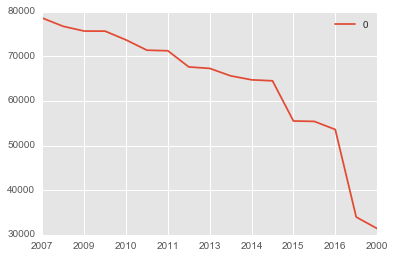

In [20]:
inspection.ACTUAL_END_DATE_year.value_counts().to_frame(0).plot()

In [23]:
violation.HPV_DAYZERO_DATE_year.value_counts()

2002    2003
2003    1964
2004    1945
2007    1841
2008    1822
2000    1815
2001    1797
2006    1729
2005    1693
2009    1545
2010    1289
2011    1204
2012    1099
2013     983
2015     861
2016     843
2014     791
Name: HPV_DAYZERO_DATE_year, dtype: int64